In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Facial Decision (Using Voting)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import shutil
import os
import glob
from collections import Counter

In [ ]:
# Load the facial model
facial_model = load_model('/content/model.h5')

# Copy photo helper function (for facial emotion recognition)
def copy_photo(source_path, dest_path='/content/photo.jpg'):
    shutil.copyfile(source_path, dest_path)
    return dest_path

# # Visualization function for emotion prediction analysis
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))

    plt.figure(figsize=(12, 6))  # Adjust figure size to accommodate both image and bar plot

    # Bar plot for emotions
    plt.subplot(1, 2, 2)  # Second subplot for the bar chart
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('Predicted Emotion Distribution')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Facial emotion recognition model for a single image
def image_ERM(image_file_path):
    emotion_labels = {
        0: 'angry',
        1: 'disgust',
        2: 'fear' ,
        3: 'happy',
        4: 'sad',
        5: 'surprise',
        6: 'neutral'
    }

    # Load and preprocess the image
    copy_photo(image_file_path)
    img = image.load_img('/content/photo.jpg', color_mode="grayscale", target_size=(48, 48))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    # Predict the emotion
    facial_prediction = facial_model.predict(x)

    # emotion_analysis(facial_prediction[0])
    predicted_class_facial = np.argmax(facial_prediction, axis=1)[0]

    # Return both the predicted class and the corresponding probabilities
    return predicted_class_facial, facial_prediction[0]

In [ ]:
def predict_emotion_from_video_using_voting(image_folder):
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    all_images = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith('.jpg')])

    frames_per_segment = 9
    results = []  # List to store the results for each 3-second segment

    for i in range(0, len(all_images), frames_per_segment):
        segment_images = all_images[i:i + frames_per_segment]
        emotion_votes = []
        probabilities = []

        for image_file in segment_images:
            predicted_class, probs = image_ERM(image_file)  # Assuming image_ERM returns class index and probabilities
            emotion_votes.append(predicted_class)
            probabilities.append(probs)

        # Get the most common emotion (based on voting)
        most_common_emotion = Counter(emotion_votes).most_common(1)[0][0]

        # Calculate mean probabilities for each emotion
        mean_probabilities = np.mean(probabilities, axis=0)

        # Get the mean probability for the most common emotion
        mean_probability_of_most_common = mean_probabilities[most_common_emotion]

        # Print the result with timestamp
        time_start = i // frames_per_segment * 3
        time_end = time_start + 3
        print(f"Time stamp ({time_start}-{time_end} seconds): Emotion displayed = {emotion_labels[most_common_emotion]}")

        # # Plot the mean probabilities as a bar graph
        # plt.figure(figsize=(10, 5))
        # plt.bar(emotion_labels, mean_probabilities, color='b', alpha=0.7)
        # plt.ylabel('Mean Probability')
        # plt.title(f'Mean Emotion Probabilities from {time_start} to {time_end} seconds')
        # plt.ylim(0, 1)  # Set y-axis limits
        # plt.axhline(y=0.5, color='r', linestyle='--', label='50% Threshold')
        # plt.legend()
        # plt.show()

        # Append the result for this segment
        results.append({
            'time_start': time_start,
            'time_end': time_end,
            'most_common_emotion': emotion_labels[most_common_emotion],
            'mean_probability_of_most_common': mean_probability_of_most_common,
            'mean_probabilities': mean_probabilities  # Store mean probabilities for later use
        })

        # Print all emotions with their mean probabilities at the end
        print("Mean Probabilities for each emotion(Video):")
        for label, mean_prob in zip(emotion_labels, mean_probabilities):
            print(f"{label}: {mean_prob:.4f}")

    return results

# Specify the folder containing the images
image_folder_path = '/content/drive/MyDrive/Jack_Test_4'

# Process the images and output the results
results = predict_emotion_from_video_using_voting(image_folder_path)

# # Example: Print the results
# for result in results:
#     # print(f"Time Start: {result['time_start']}s, Time End: {result['time_end']}s")
#     # print(f"Most Common Emotion: {result['most_common_emotion']}")
#     print(f"Mean Probability of Most Common Emotion: {result['mean_probability_of_most_common']:.4f}")
#     print("Mean Probabilities for all emotions:")
#     for label, prob in zip(emotion_labels, result['mean_probabilities']):
#         print(f"  {label}: {prob:.4f}")
#     print("-" * 50)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Jack_Test_4'

.

Audio Decision


In [ ]:
!pip install resampy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 67.2 MB/s eta 0:00:00


In [ ]:
!pip install librosa

In [ ]:
import numpy as np
import librosa
from keras.models import load_model

# Load the audio model
audio_model = load_model('/content/cnn_model.h5')

# Audio feature extraction function
def extract_mfcc(file_path, sr=22050, n_mfcc=40):
    y, sr = librosa.load(file_path, sr=sr, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    return mfccs_mean

# Function to predict audio probabilities and map calm to neutral
def get_audio_probabilities(audio_file_path):
    mfcc_features = extract_mfcc(audio_file_path)
    mfcc_features_reshaped = np.expand_dims(mfcc_features, axis=0)
    mfcc_features_reshaped = np.expand_dims(mfcc_features_reshaped, axis=2)

    # Predict probabilities using the audio model
    audio_prediction = audio_model.predict(mfcc_features_reshaped)
    print(audio_prediction)
    # Audio emotion labels
    audio_emotion_labels = {
        1: 'neutral',
        2: 'calm',   # Will be merged with 'neutral'
        3: 'happy',
        4: 'sad',
        5: 'angry',
        6: 'fearful',
        7: 'disgust',
        8: 'surprised'
    }

    # Map 'calm' (class 2) to 'neutral' (class 1) in the audio model
    audio_probs = audio_prediction[0]
    audio_probs[1] += audio_probs[2]  # Add 'calm' probability to 'neutral'
    audio_probs = np.delete(audio_probs, 2)  # Remove 'calm' class (index 2)
    print(audio_probs)
    return audio_probs  # Return adjusted probabilities

In [ ]:
# Function to predict emotion from audio and return the displayed emotion and its probability
def predict_emotion_from_audio(audio_file_path):
    # Step 1: Get the adjusted audio probabilities
    audio_probs = get_audio_probabilities(audio_file_path)

    # Image emotion labels to match audio model (remapped for consistency)
    image_emotion_labels = {
        0: 'angry',
        1: 'disgust',
        2: 'fear',
        3: 'happy',
        4: 'sad',
        5: 'surprise',
        6: 'neutral'  # Mapping 'calm' to 'neutral'
    }

    # Step 2: Print the probabilities for each emotion
    print("Probabilities for each emotion after mapping(Audio):")
    for idx, prob in enumerate(audio_probs):
        print(f"{image_emotion_labels[idx]}: {prob:.4f}")

    # Step 3: Determine the final predicted emotion and its probability
    final_predicted_class = np.argmax(audio_probs)
    final_predicted_emotion = image_emotion_labels[final_predicted_class]
    final_predicted_probability = audio_probs[final_predicted_class]

    # Step 4: Print the final predicted emotion and probability
    print(f"Final Predicted Emotion: {final_predicted_emotion}, Probability: {final_predicted_probability:.4f}")

    # Step 5: Return the predicted emotion, probability, and all probabilities
    return final_predicted_emotion, final_predicted_probability, audio_probs

# Example usage:
# audio_file_path = '/content/Jack_Clip1_Segment_4_start=9.0.mp3'
# predicted_emotion, emotion_probability, all_probabilities = predict_emotion_from_audio(audio_file_path)
# print(f"Predicted emotion: {predicted_emotion}, Probability: {emotion_probability}")

.

Decision Fusion

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Function to check if the audio contains speech or silence
def is_speech_in_audio(file_path, threshold=0.001):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Calculate the Root Mean Square Energy (RMSE) of the audio
    rmse = librosa.feature.rms(y=y)[0]

    # Calculate the mean RMSE (energy level)
    mean_rmse = np.mean(rmse)

    # If the mean RMSE exceeds the threshold, we consider it as speech
    return mean_rmse > threshold

METHOD USED: FUSION PROBABILITIES calculated for all emotions

In [ ]:
# # Assuming the functions 'get_audio_probabilities' and 'get_facial_probabilities' are defined elsewhere
# # Also assuming 'image_ERM' function is implemented to get the class and probabilities for the facial images

# # Perform decision-level fusion for 3-second segments
# def decision_fusion(audio_file_path, image_folder_path):
#     # Step 1: Get audio probabilities and predicted emotion from the audio
#     predicted_emotion_audio, emotion_probability_audio, all_probs_audio = predict_emotion_from_audio(audio_file_path)

#     # Step 2: Process facial images in the specified folder using video
#     video_results = predict_emotion_from_video_using_voting(image_folder_path)

#     # Emotion labels for consistency
#     image_emotion_labels = {
#         0: 'angry',
#         1: 'disgust',
#         2: 'fear',
#         3: 'happy',
#         4: 'sad',
#         5: 'surprise',
#         6: 'neutral'  # Mapping 'calm' to 'neutral'
#     }

#     # Group the results of the video into a list of probabilities for fusion
#     video_combined_probs = []
#     for result in video_results:
#         mean_probabilities = result['mean_probabilities']
#         video_combined_probs.append(mean_probabilities)

#     # Calculate dynamic weights based on speech in audio
#     speech_detected = is_speech_in_audio(audio_file_path)
#     if speech_detected:
#         weight_audio, weight_facial = 0.4, 0.6
#         print("IS_SPEECH_IN_AUDIO: True")
#     else:
#         weight_audio, weight_facial = 0.0, 1.0
#         print("IS_SPEECH_IN_AUDIO: False")

#     # Initialize a list to store fused results
#     final_fusion_results = []

#     # Perform fusion for each segment
#     for segment_idx, video_probs in enumerate(video_combined_probs):
#         # Get the audio probabilities for the current segment (use the first probability set for simplicity here)
#         audio_probs_segment = all_probs_audio  # Assuming the audio probabilities are constant for the entire segment

#         # Perform weighted fusion of audio and video probabilities
#         fused_probs = weight_audio * audio_probs_segment + weight_facial * video_probs

#         # Get the final predicted emotion by selecting the emotion with the highest fused probability
#         final_predicted_class = np.argmax(fused_probs)
#         final_predicted_emotion = image_emotion_labels[final_predicted_class]

#         # Store the results for this segment
#         final_fusion_results.append({
#             'segment': segment_idx + 1,
#             'fused_probabilities': fused_probs,
#             'predicted_emotion': final_predicted_emotion,
#             'max_probability': fused_probs[final_predicted_class]
#         })

#         # Print the fused probabilities for this segment
#         print(f"Segment {segment_idx + 1} - Fused Probabilities after taking weighted average:")
#         for idx, prob in enumerate(fused_probs):
#             print(f"{image_emotion_labels[idx]}: {prob:.4f}")

#         print(f"Predicted Emotion: {final_predicted_emotion} with Probability: {fused_probs[final_predicted_class]:.4f}")

#     return final_fusion_results


# # Example usage:
# audio_file_path = '/content/Jack_Clip1_Segment_4_start=9.0.mp3'
# image_folder_path = '/content/drive/MyDrive/Jack_Test_4'  # Replace with your actual image folder path

# # Perform decision-level fusion and predict the final emotion
# final_results = decision_fusion(audio_file_path, image_folder_path)


METHOD USED: FUSION PROBABILITIES only for the predicted emotion from audio and video
(Currently being used)

In [ ]:
def decision_fusion_2(audio_file_path, image_folder_path):
    # Step 1: Get audio probabilities and predicted emotion from the audio
    predicted_emotion_audio, emotion_probability_audio, all_probs_audio = predict_emotion_from_audio(audio_file_path)

    # Step 2: Process facial images in the specified folder using video
    video_results = predict_emotion_from_video_using_voting(image_folder_path)

    # Emotion labels for consistency
    image_emotion_labels = {
        0: 'angry',
        1: 'disgust',
        2: 'fear',
        3: 'happy',
        4: 'sad',
        5: 'surprise',
        6: 'neutral'  # Mapping 'calm' to 'neutral'
    }

    # Group the results of the video into a list of probabilities for fusion
    video_combined_probs = []
    for result in video_results:
        mean_probabilities = result['mean_probabilities']
        video_combined_probs.append(mean_probabilities)

    # Calculate dynamic weights based on speech in audio
    speech_detected = is_speech_in_audio(audio_file_path)
    if speech_detected:
        weight_audio, weight_video = 0.35, 0.65
        print("IS_SPEECH_IN_AUDIO: True")
    else:
        weight_audio, weight_video = 0.0, 1.0
        print("IS_SPEECH_IN_AUDIO: False")

    # Initialize a list to store fused results
    final_fusion_results = []

    # Perform fusion for each segment
    for segment_idx, video_probs in enumerate(video_combined_probs):
        # Get the audio probabilities for the current segment (assuming it's constant across the segment)
        audio_probs_segment = all_probs_audio

        # Find the maximum probability and corresponding emotion for audio and video
        max_audio_prob = np.max(audio_probs_segment)
        max_video_prob = np.max(video_probs)

        # Apply the weights based on whether speech was detected
        weighted_audio = weight_audio * max_audio_prob
        weighted_video = weight_video * max_video_prob

        # Determine which modality has the greater weighted probability
        if weighted_audio > weighted_video:
            final_predicted_emotion = predicted_emotion_audio
            max_probability = max_audio_prob
        else:
            final_predicted_class = np.argmax(video_probs)
            final_predicted_emotion = image_emotion_labels[final_predicted_class]
            max_probability = max_video_prob

        # Store the results for this segment
        final_fusion_results.append({
            'segment': segment_idx + 1,
            'predicted_emotion': final_predicted_emotion,
            'max_probability': max_probability
        })

        # Print the decision for this segment
        print(f"Segment {segment_idx + 1} - Predicted Emotion: {final_predicted_emotion} with Max Probability: {max_probability:.4f}")

    return final_fusion_results

# # Example usage:
# audio_file_path = '/content/Jack_Clip1_Segment_4_start=9.0.mp3'
# image_folder_path = '/content/drive/MyDrive/Jack_Test_4'  # Replace with your actual image folder path

# # Perform decision-level fusion and predict the final emotion
# final_results = decision_fusion_2(audio_file_path, image_folder_path)


.

CONTINUOUS DISPLAY OF EMOTIONS FOR WHOLE CLIP AND CREATION OF AN EXCEL DOCUMENT CONTAINING THE DATA OF EMOTION DISPLAYED

In [ ]:
import pandas as pd

In [ ]:
def continuous_emotion_display(audio_folder, video_folder, output_excel):
    # List all audio files and subfolders containing frames
    audio_files = sorted([os.path.join(audio_folder, f) for f in os.listdir(audio_folder) if f.endswith('.mp3')])
    video_folders = sorted([os.path.join(video_folder, d) for d in os.listdir(video_folder) if os.path.isdir(os.path.join(video_folder, d))])

    # Initialize an empty list to store the results
    data = []

    for idx, (audio_file, video_subfolder) in enumerate(zip(audio_files, video_folders)):
        # Step 1: Predict emotion from audio
        predicted_emotion_audio, emotion_probability_audio, all_probs_audio = predict_emotion_from_audio(audio_file)

        # Step 2: Predict emotion from video frames in the subfolder
        video_results = predict_emotion_from_video_using_voting(video_subfolder)
        predicted_emotion_video = video_results[0]['most_common_emotion']
        emotion_probability_video = video_results[0]['mean_probability_of_most_common']

        # Step 3: Determine if speech is present in the audio
        is_speech = is_speech_in_audio(audio_file)

        # Step 4: Perform decision fusion
        fused_results = decision_fusion_2(audio_file, video_subfolder)
        fusion_emotion = fused_results[0]['predicted_emotion']
        fusion_probability = fused_results[0]['max_probability']

        # Step 5: Store results in the data list
        start_time = idx * 3  # Assuming 3 seconds per segment
        data.append({
            'segment_number': idx + 1,
            'start_time': start_time,
            'audio_emotion_predicted': predicted_emotion_audio,
            'audio_probability': emotion_probability_audio,
            'video_emotion_predicted': predicted_emotion_video,
            'video_probability': emotion_probability_video,
            'Is_speech_in_audio': is_speech,
            'fusion_emotion_predicted': fusion_emotion,
            'fusion_probability': fusion_probability
        })

    # Step 6: Create a DataFrame and save it as an Excel sheet
    df = pd.DataFrame(data)
    df.to_excel(output_excel, index=False)
    print(f"Results saved to {output_excel}")

# Example usage
audio_folder_path = '/content/drive/MyDrive/Capstone/Sky_Clips/Sky_Clip6/Sky_Clip6_Audio_Dataset'
video_folder_path = '/content/drive/MyDrive/Capstone/Sky_Clips/Sky_Clip6/Sky_Clip6_Video_subfolders'
output_excel_path = '/content/drive/MyDrive/Capstone/Sky_Clips/Sky_Clip6/Final_Output_SKy_Clip6.xlsx'

continuous_emotion_display(audio_folder_path, video_folder_path, output_excel_path)


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Time stamp (0-3 seconds): Emotion displayed = sad
Mean Probabilities for each emotion(Video):
angry: 0.1493
disgust: 0.0001
fear: 0.1925
happy: 0.0083
sad: 0.5121
surprise: 0.1376
neutral: 0.0001
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[5.8106632e-17 9.9737763e-01 3.8129979e-30 1.6262041e-19 4.3582572e-28
  2.6224388e-03 1.1764950e-14 9.2234749e-28]]
[5.8106632e-17 9.9737763e-01 1.6262041e-19 4.3582572e-28 2.6224388e-03
 1.1764950e-14 9.2234749e-28]
Probabilities for each emotion after mapping(Audio):
angry: 0.0000
disgust: 0.9974
fear: 0.0000
happy: 0.0000
sad: 0.0026
surprise: 0.0000
neutral: 0.0000
Final Predicted Emotion: disgust, Probability: 0.9974
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━

.

PLOT OF EMOTIONS (ALL 3: AUDIO, VIDEO, FUSION)

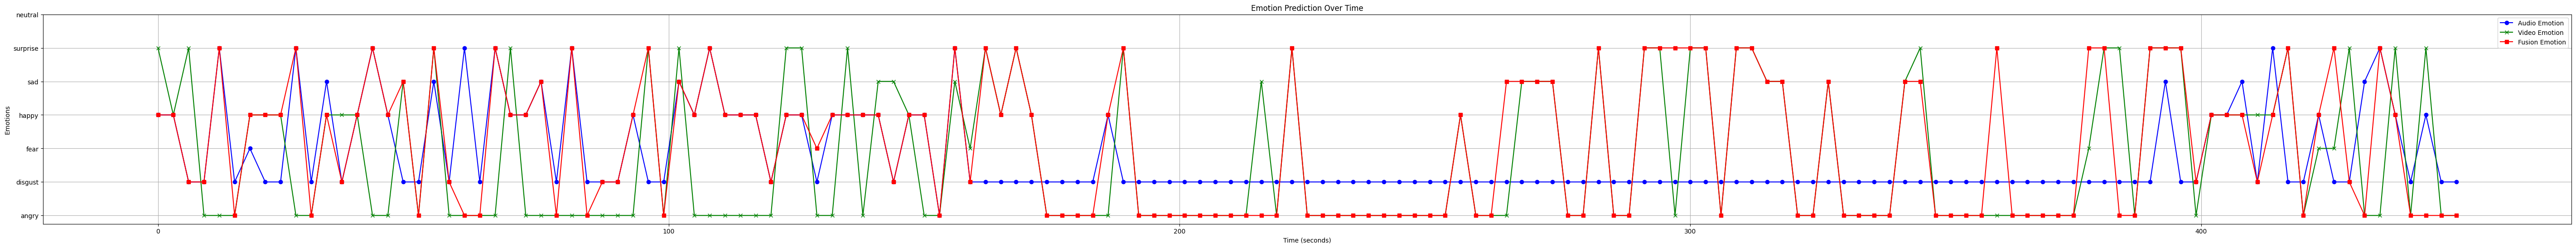

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_emotions_from_excel(excel_file):
    # Step 1: Load the data from the Excel sheet
    df = pd.read_excel(excel_file)

    # Step 2: Define emotion labels and assign them numerical values for the y-axis
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    emotion_to_value = {emotion: idx for idx, emotion in enumerate(emotion_labels)}

    # Step 3: Convert emotions to numeric values for plotting
    df['audio_emotion_value'] = df['audio_emotion_predicted'].map(emotion_to_value)
    df['video_emotion_value'] = df['video_emotion_predicted'].map(emotion_to_value)
    df['fusion_emotion_value'] = df['fusion_emotion_predicted'].map(emotion_to_value)

    # Step 4: Plot the emotions
    plt.figure(figsize=(72, 6))  # Make the figure 6 times wider (6 * 12 = 72)

    # Plot audio emotions
    plt.plot(df['start_time'], df['audio_emotion_value'], label='Audio Emotion', marker='o', color='b')

    # Plot video emotions
    plt.plot(df['start_time'], df['video_emotion_value'], label='Video Emotion', marker='x', color='g')

    # Plot fusion emotions
    plt.plot(df['start_time'], df['fusion_emotion_value'], label='Fusion Emotion', marker='s', color='r')

    # Step 5: Customize the plot
    plt.yticks(range(len(emotion_labels)), emotion_labels)  # Set y-axis labels as emotion names
    plt.xlabel('Time (seconds)')
    plt.ylabel('Emotions')
    plt.title('Emotion Prediction Over Time')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Step 6: Display the plot
    plt.show()


# Example usage
excel_file_path = '/content/drive/MyDrive/Jack_Dataset_Clip1/Final_Output.xlsx'
plot_emotions_from_excel(excel_file_path)

PLOT OF EMOTIONS (ONLY FUSION)

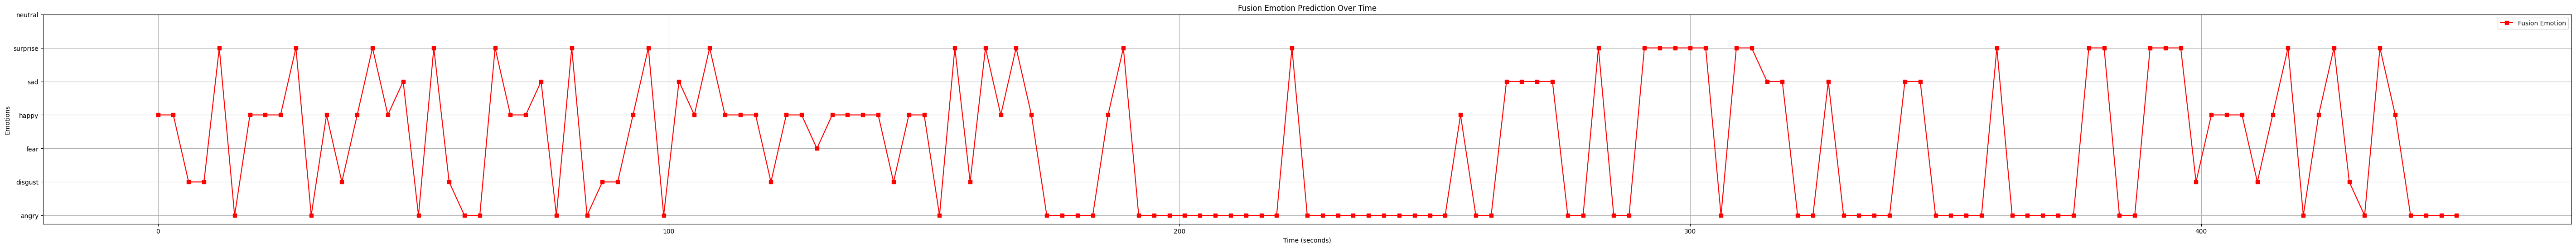

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_fusion_emotion_from_excel(excel_file):
    # Step 1: Load the data from the Excel sheet
    df = pd.read_excel(excel_file)

    # Step 2: Define emotion labels and assign them numerical values for the y-axis
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    emotion_to_value = {emotion: idx for idx, emotion in enumerate(emotion_labels)}

    # Step 3: Convert fusion emotions to numeric values for plotting
    df['fusion_emotion_value'] = df['fusion_emotion_predicted'].map(emotion_to_value)

    # Step 4: Plot the fusion emotions
    plt.figure(figsize=(72, 6))  # Set the figure size to be 6 times wider

    # Plot fusion emotions
    plt.plot(df['start_time'], df['fusion_emotion_value'], label='Fusion Emotion', marker='s', color='r')

    # Step 5: Customize the plot
    plt.yticks(range(len(emotion_labels)), emotion_labels)  # Set y-axis labels as emotion names
    plt.xlabel('Time (seconds)')
    plt.ylabel('Emotions')
    plt.title('Fusion Emotion Prediction Over Time')
    plt.legend(loc='upper right')
    plt.grid(True)

    # Step 6: Display the plot
    plt.show()

# Example usage
excel_file_path = '/content/drive/MyDrive/Jack_Dataset_Clip1/Final_Output.xlsx'
plot_fusion_emotion_from_excel(excel_file_path)


.

Code to check emotion displayed by each Frame in a segment

Processing: /content/drive/MyDrive/Kastaclysm_Clip1/Kastaclysm_Clip1_Video_subfolders/batch_73/face_3min_36sec_0frame.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Facial predicted emotion for face_3min_36sec_0frame.jpg: sad


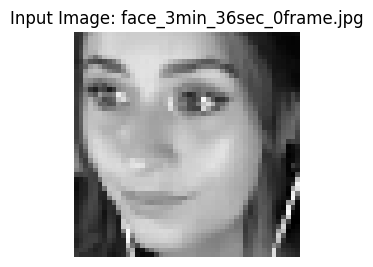

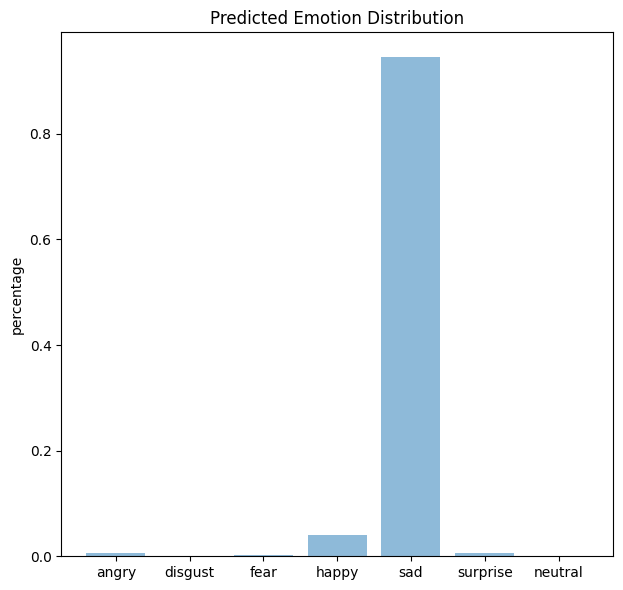

Processing: /content/drive/MyDrive/Kastaclysm_Clip1/Kastaclysm_Clip1_Video_subfolders/batch_73/face_3min_36sec_20frame.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Facial predicted emotion for face_3min_36sec_20frame.jpg: fear


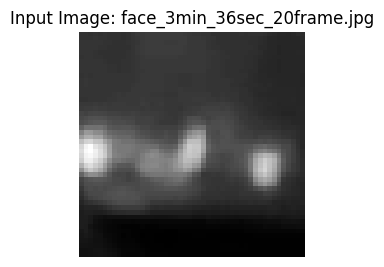

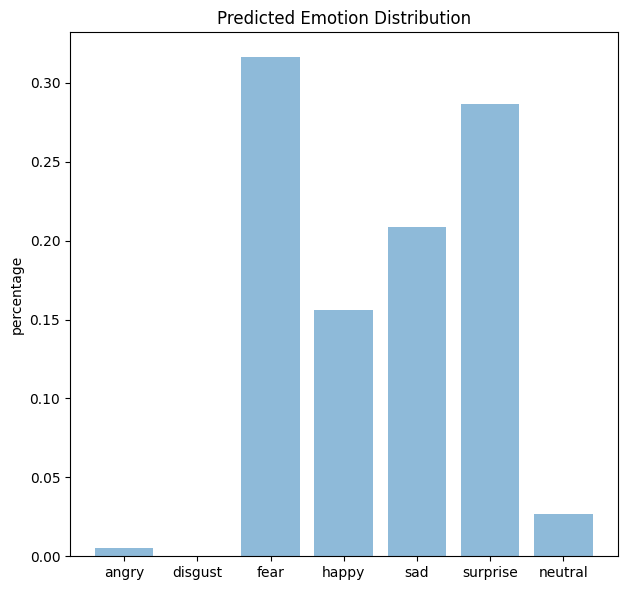

Processing: /content/drive/MyDrive/Kastaclysm_Clip1/Kastaclysm_Clip1_Video_subfolders/batch_73/face_3min_36sec_40frame.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Facial predicted emotion for face_3min_36sec_40frame.jpg: sad


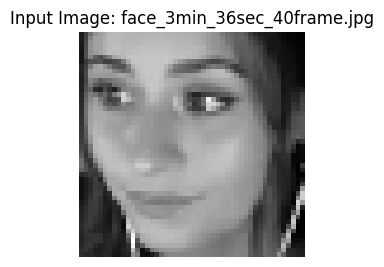

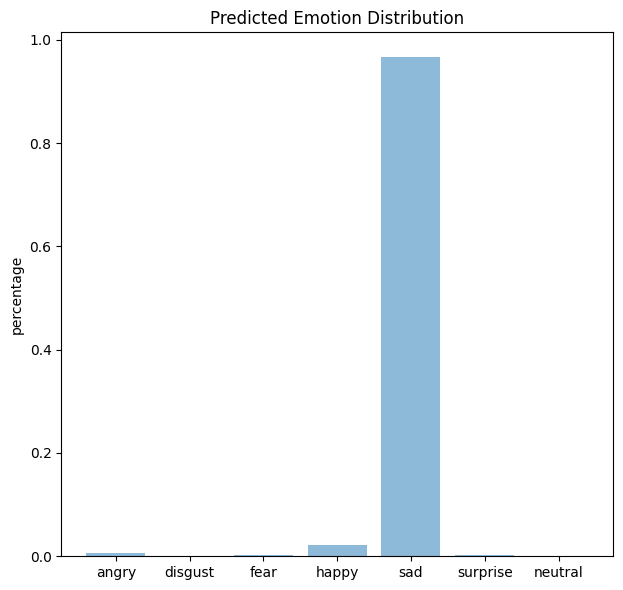

Processing: /content/drive/MyDrive/Kastaclysm_Clip1/Kastaclysm_Clip1_Video_subfolders/batch_73/face_3min_37sec_0frame.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Facial predicted emotion for face_3min_37sec_0frame.jpg: sad


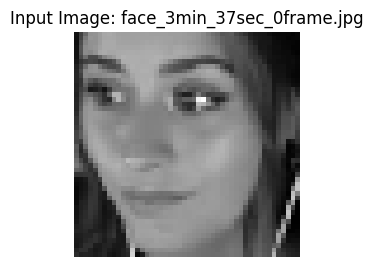

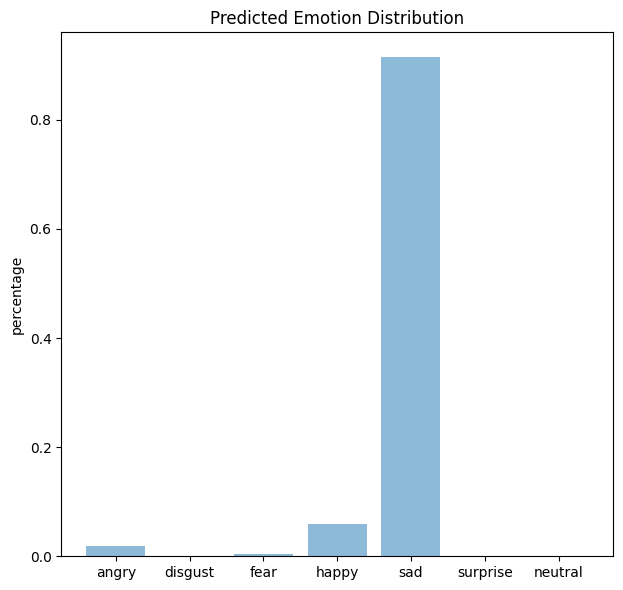

Processing: /content/drive/MyDrive/Kastaclysm_Clip1/Kastaclysm_Clip1_Video_subfolders/batch_73/face_3min_37sec_20frame.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Facial predicted emotion for face_3min_37sec_20frame.jpg: sad


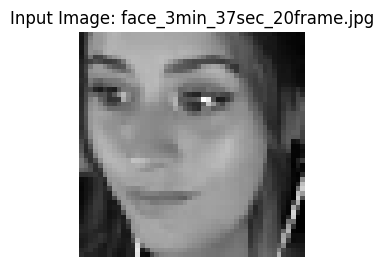

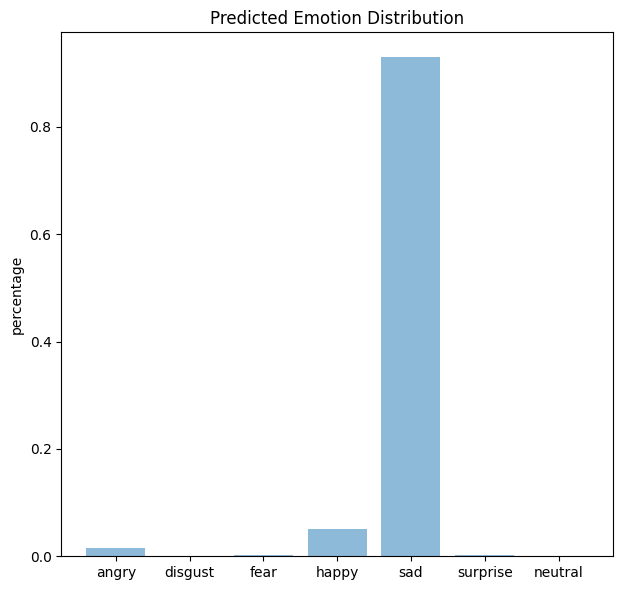

Processing: /content/drive/MyDrive/Kastaclysm_Clip1/Kastaclysm_Clip1_Video_subfolders/batch_73/face_3min_37sec_40frame.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Facial predicted emotion for face_3min_37sec_40frame.jpg: sad


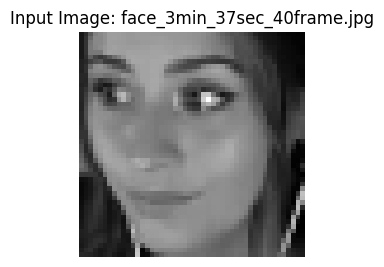

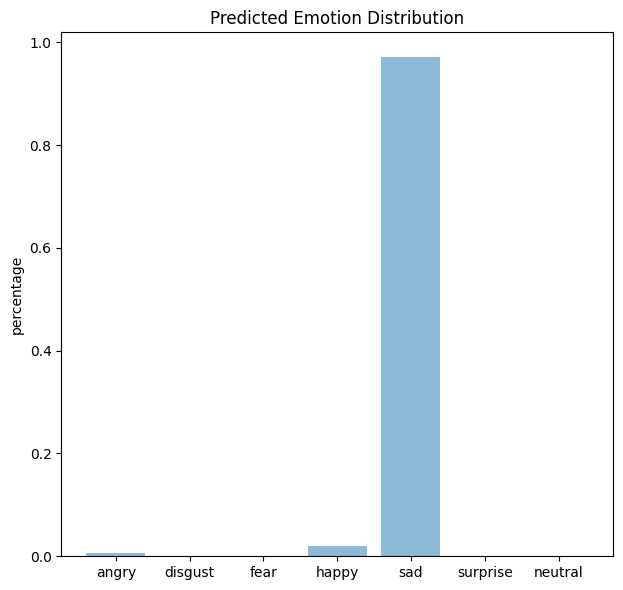

Processing: /content/drive/MyDrive/Kastaclysm_Clip1/Kastaclysm_Clip1_Video_subfolders/batch_73/face_3min_38sec_0frame.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Facial predicted emotion for face_3min_38sec_0frame.jpg: sad


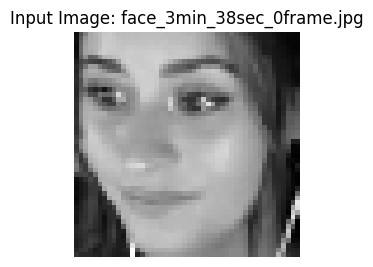

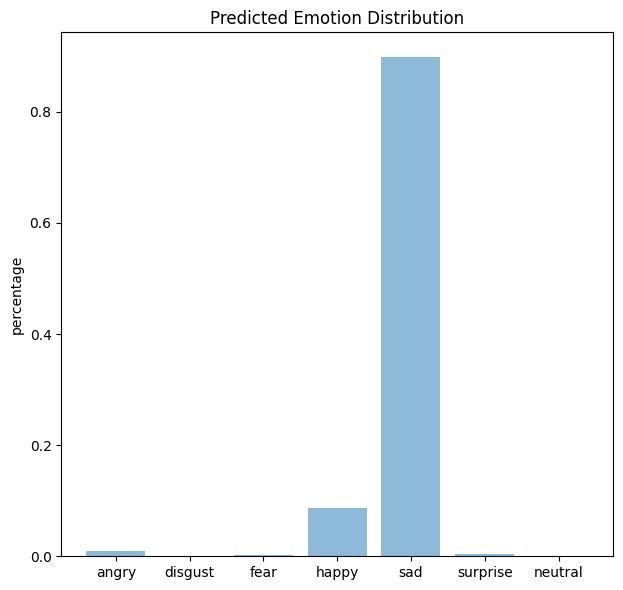

Processing: /content/drive/MyDrive/Kastaclysm_Clip1/Kastaclysm_Clip1_Video_subfolders/batch_73/face_3min_38sec_20frame.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Facial predicted emotion for face_3min_38sec_20frame.jpg: sad


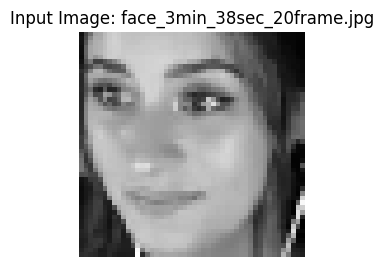

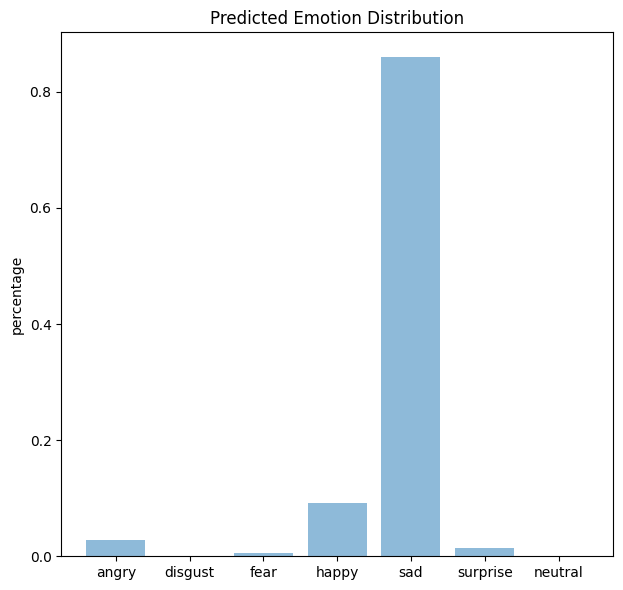

Processing: /content/drive/MyDrive/Kastaclysm_Clip1/Kastaclysm_Clip1_Video_subfolders/batch_73/face_3min_38sec_40frame.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Facial predicted emotion for face_3min_38sec_40frame.jpg: sad


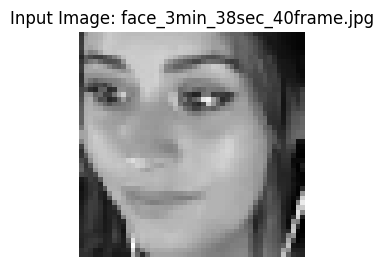

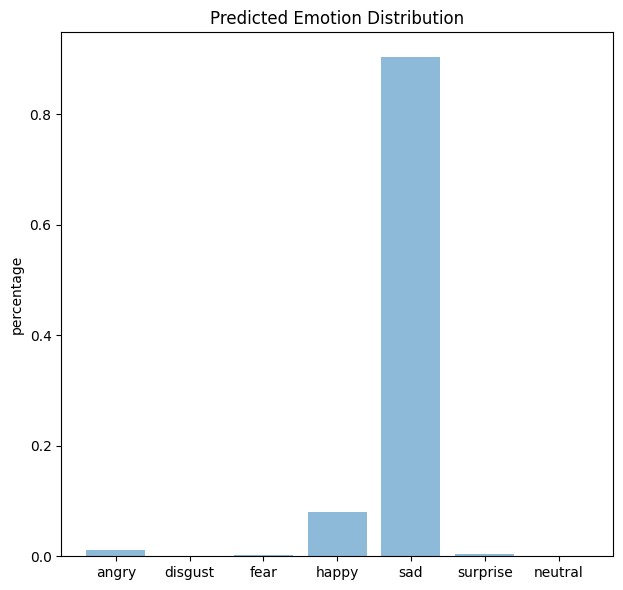

In [ ]:
# Perform facial emotion recognition model (ERM) and display image
def image_ERM(image_file_path):
    # Updated unified emotion mapping (aligning both audio and facial models to specified order)
    emotion_labels = {
        0: 'angry',       # 0
        1: 'disgust',     # 1
        2: 'fear',        # 2
        3: 'happy',       # 3
        4: 'sad',         # 4
        5: 'surprise',    # 5
        6: 'neutral'      # 6 (includes both 'neutral' and 'calm')
    }

    # Step 1: Copy image to a known path
    copy_photo(source_path=image_file_path)
    file = '/content/photo.jpg'

    # Step 2: Facial model prediction
    img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

    # Display the image using matplotlib
    plt.subplot(1, 2, 1)  # First subplot for the image
    plt.imshow(img, cmap='gray')  # Show the image in grayscale
    plt.title(f"Input Image: {os.path.basename(image_file_path)}")
    plt.axis('off')  # Hide axis for the image

    # Step 3: Preprocess the image for model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x /= 255.0

    # Step 4: Make prediction
    facial_prediction = facial_model.predict(x)

    # Show the emotion distribution
    emotion_analysis(facial_prediction[0])

    # Get predicted class (emotion with the highest probability)
    predicted_class_facial = np.argmax(facial_prediction, axis=1)[0]
    predicted_emotion = emotion_labels[predicted_class_facial]

    # Print the predicted emotion
    print(f'Facial predicted emotion for {os.path.basename(image_file_path)}: {predicted_emotion}')

    # Show the plots (image + emotion analysis)
    plt.tight_layout()
    plt.show()

    return predicted_emotion

# Process all images in the folder
def process_images_in_folder(image_folder_path):
    # Get the list of all images (assumed to be .jpg format) in the folder
    image_files = sorted(glob.glob(os.path.join(image_folder_path, '*.jpg')))

    # Iterate through all images in the folder and perform emotion recognition
    for image_file in image_files:
        print(f"Processing: {image_file}")
        image_ERM(image_file)

# Folder path for images in your Google Drive
image_folder_path = '/content/drive/MyDrive/Kastaclysm_Clip1/Kastaclysm_Clip1_Video_subfolders/batch_73'

# Run the process for all images in the folder
process_images_in_folder(image_folder_path)